In [95]:
### Attempting to get the formula for TSS from garmin data ###

# Import necessary modules and functions
import os, datetime
import pandas as pd
from ETL.ETL_general import update_incremental, update_incremental_api, get_most_recent_date, export_to_gsheets
from ETL.ETL_garmin_api import init_garmin, get_garmin_data

garmin_file = 'Data/Cleaned/Garmin_daily.csv'
email_g = os.getenv("USERNAME_G")
password_g = os.getenv("PASSWORD_G")
api = init_garmin(email_g, password_g)

# Get TP data
df_t = pd.read_csv('Data/Cleaned/TSS metrics.csv')
df_t['date'] = pd.to_datetime(df_t['date']).dt.date
df_t = df_t[['date', 'TSS']]

# Get Garmin data
start_date = df_t['date'].min()
data_list = api.get_activities_by_date(start_date, datetime.date.today(), activitytype='running')
# Convert list of dictionaries to DataFrame
df_g = pd.DataFrame(data_list)
# Keep only relevant columns
df_g = df_g[['activityId',
            'activityName',
            'startTimeLocal',
            'distance',
           # 'movingDuration',
            'elevationGain',
           # 'elevationLoss',
            'averageSpeed',
            'maxSpeed',
            'calories',
            'averageHR'
           # 'maxHR',
           # 'maxElevation',
           # 'activityTrainingLoad']]
]]
# Add date column as date
df_g['date'] = pd.to_datetime(df_g['startTimeLocal']).dt.date
df_g = df_g[['date'] + [col for col in df_g.columns if col != 'date']]

# Merge the two dataframes
df = pd.merge(df_g, df_t, on='date', how='inner')
df.head()

,date,activityId,activityName,startTimeLocal,distance,elevationGain,averageSpeed,maxSpeed,calories,averageHR,TSS
0,2024-05-19,15464994914,Madrid Carrera,2024-05-19 07:05:06,18280.839844,179.52,3.212,4.161,1220.0,148.0,139.90
1,2024-05-17,15433085610,Madrid - 12x300,2024-05-17 07:01:40,9279.959961,41.89,3.009,4.665,652.0,159.0,64.28
2,2024-05-15,15403874461,Madrid Carrera,2024-05-15 11:30:44,17284.039062,164.94,3.232,3.863,1176.0,160.0,131.88
3,2024-05-12,15360575155,Madrid Carrera,2024-05-12 19:09:09,3679.590088,17.46,3.435,3.928,229.0,142.0,82.69
4,2024-05-11,15342915004,Guadarrama Trail running,2024-05-11 17:31:36,8943.410156,256.34,3.286,5.039,653.0,168.0,78.11


In [96]:
### Get the raw TP data and see which days have more than one training, eliminate those
# Load workout data from CSV
df_tr = pd.read_csv('Data/TrainingPeaks/workouts.csv', parse_dates=['WorkoutDay'])

# Get number of workouts per day
df_tr.rename(columns={'WorkoutDay': 'date'}, inplace=True)
df_tr['count'] = df_tr.groupby('date')['date'].transform('count')
df_tr = df_tr[['date', 'count']]
df_tr['date'] = pd.to_datetime(df_tr['date']).dt.date

# Merge the two dataframes
df = pd.merge(df, df_tr, on='date', how='left')
# Delete rows with more than one workout
df = df[df['count'] == 1]
df.drop(columns=['count'], inplace=True)

In [97]:
import pandas as pd
import statsmodels.api as sm

# Assuming the dataset is already loaded into a DataFrame named df
data = df.copy()

# Drop columns that are not needed for the model
data = data.drop(columns=['activityId', 'activityName', 'startTimeLocal', 'date'])

# Convert all columns to numeric, coerce errors to handle non-numeric values
data = data.apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
data = data.dropna()
data.head()

,distance,elevationGain,averageSpeed,maxSpeed,calories,averageHR,TSS
0,18280.839844,179.52,3.212,4.161,1220.0,148.0,139.90
1,9279.959961,41.89,3.009,4.665,652.0,159.0,64.28
2,17284.039062,164.94,3.232,3.863,1176.0,160.0,131.88
5,8943.410156,256.34,3.286,5.039,653.0,168.0,78.11
6,11570.459961,40.29,3.092,4.647,827.0,160.0,82.38


In [98]:
# Define features and target variable
X = data.drop(columns=['TSS'])  # Features
y = data['TSS']  # Target variable (TSS)

# Split the data into training and testing sets
train_size = int(0.8 * len(data))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create and train the regression model
model = sm.OLS(y_train, X_train).fit()

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = ((y_test - y_pred) ** 2).mean()
r2 = model.rsquared

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Summary of the model
print(model.summary())

Mean Squared Error: 17.08857408606121
R^2 Score: 0.9964112201339146
                                 OLS Regression Results                                
Dep. Variable:                    TSS   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.996
Method:                 Least Squares   F-statistic:                              4165.
Date:                Sun, 19 May 2024   Prob (F-statistic):                   1.01e-107
Time:                        18:57:32   Log-Likelihood:                         -292.56
No. Observations:                  96   AIC:                                      597.1
Df Residuals:                      90   BIC:                                      612.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      

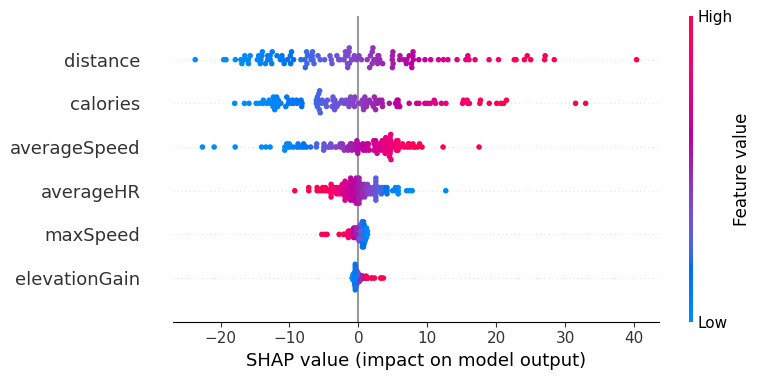

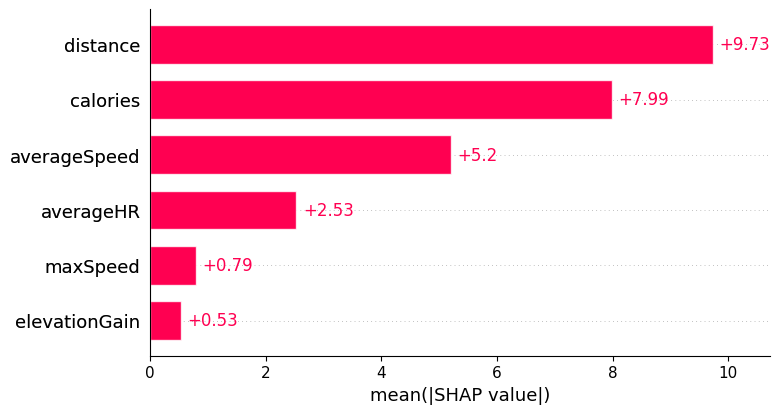

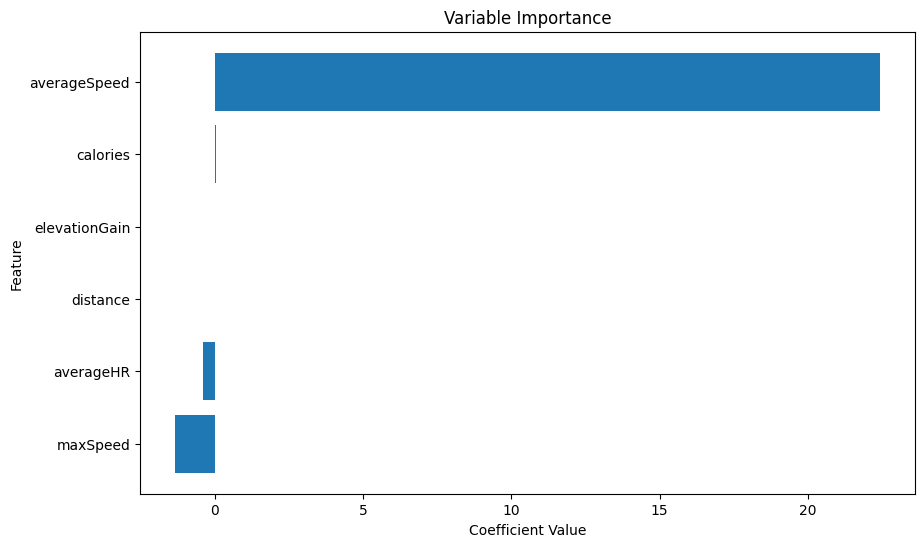

In [99]:
import matplotlib.pyplot as plt
import shap

# Create a SHAP explainer for the linear regression model
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

# Plot SHAP values
shap.summary_plot(shap_values, X)

# Plot SHAP values for individual feature
shap.plots.bar(shap_values)

# Calculate and plot variable importance
importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.params})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Variable Importance')
plt.gca().invert_yaxis()
plt.show()

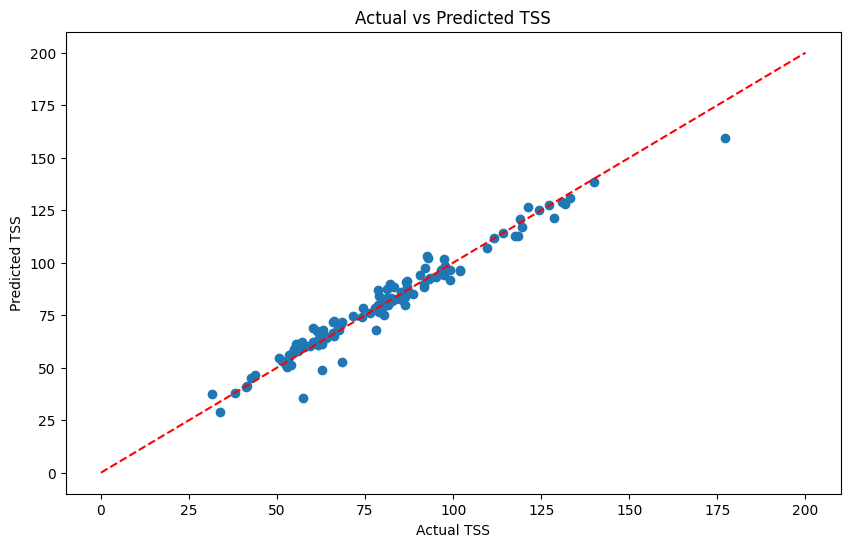

,date,activityId,activityName,startTimeLocal,distance,elevationGain,averageSpeed,maxSpeed,calories,averageHR,TSS,Predicted_TSS
5,2024-05-11,15342915004,Guadarrama Trail running,2024-05-11 17:31:36,8943.410156,256.34,3.286,5.039,653.0,168.0,78.11,68.187103
17,2024-04-21,15001860838,Madrid Trail running,2024-04-21 08:58:10,14196.679688,222.08,2.604,3.751,986.0,137.0,92.69,103.154967
25,2024-04-07,14774594162,Madrid Carrera,2024-04-07 09:18:16,21315.210938,151.70,3.575,4.357,1472.0,174.0,177.12,159.156747
71,2024-01-07,13396372172,Madrid Carrera,2024-01-07 10:22:04,9356.860352,41.58,2.579,3.966,648.0,146.0,55.51,61.275248
81,2023-12-03,12962163156,Madrid Carrera,2023-12-03 08:30:18,6727.450195,31.82,2.017,4.283,460.0,125.0,31.42,37.420131
85,2023-11-21,12814404607,Madrid Carrera,2023-11-21 07:34:57,6872.709961,51.21,2.093,4.572,536.0,144.0,57.44,35.446222
90,2023-11-09,12661747255,"Madrid - 5x10min,2",2023-11-09 08:35:36,9815.280273,39.05,2.718,3.312,696.0,150.0,61.34,67.675793
94,2023-11-01,12553342624,"Madrid - 10x5min, 2min",2023-11-01 09:44:07,10722.879883,24.72,2.428,3.303,775.0,149.0,60.16,68.711605
97,2023-10-24,12444190964,Madrid Carrera,2023-10-24 07:13:47,5045.009766,52.33,2.802,3.760,394.0,168.0,33.74,28.788827
110,2023-08-01,11692495489,Madrid Carrera,2023-08-01 19:25:58,12593.019531,91.58,2.551,4.236,901.0,143.0,78.71,86.851503


In [100]:
# Make predictions on the dataset
df['Predicted_TSS'] = model.predict(X)

# Plot predicted vs real values as xy chart
plt.figure(figsize=(10, 6))
plt.scatter(df['TSS'], df['Predicted_TSS'])
plt.plot([0, 200], [0, 200], color='red', linestyle='--')
plt.xlabel('Actual TSS')
plt.ylabel('Predicted TSS')
plt.title('Actual vs Predicted TSS')
plt.show()

# Calculate the absolute difference between actual and predicted TSS
df['Absolute_Error'] = abs(df['TSS'] - df['Predicted_TSS'])

# Create a new dataset with cases where the absolute error is greater than 10 percent
off_by_more_than_10 = df[df['Absolute_Error'] > 0.1 * df['TSS']]

# Drop the 'Absolute_Error' column if no longer needed
off_by_more_than_10 = off_by_more_than_10.drop(columns=['Absolute_Error'])

off_by_more_than_10

In [101]:
# Print % of activities with Prediction Error > 10%
print(f'Activities with Prediction Error > 10%: {len(off_by_more_than_10) / len(df) * 100:.2f}%')

Activities with Prediction Error > 10%: 9.76%
